In [ ]:
# Parameters
path = "/home/kamran.karimi1/Project/git/CrystalPlasticity/postprocess/../testRuns/test/Run0"


# import libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
from scipy.interpolate import Rbf
#
matplotlib.rcParams['text.usetex'] = True
warnings.filterwarnings('ignore')
#
#path = '../testRuns/test/' #--- comment if passed by argument

In [2]:
import scipy.interpolate
help(scipy.interpolate.interp2d)

Help on class interp2d in module scipy.interpolate.interpolate:

class interp2d(__builtin__.object)
 |  interp2d(x, y, z, kind='linear', copy=True, bounds_error=False,
 |           fill_value=nan)
 |  
 |  Interpolate over a 2-D grid.
 |  
 |  `x`, `y` and `z` are arrays of values used to approximate some function
 |  f: ``z = f(x, y)``. This class returns a function whose call method uses
 |  spline interpolation to find the value of new points.
 |  
 |  If `x` and `y` represent a regular grid, consider using
 |  RectBivariateSpline.
 |  
 |  Note that calling `interp2d` with NaNs present in input values results in
 |  undefined behaviour.
 |  
 |  Methods
 |  -------
 |  __call__
 |  
 |  Parameters
 |  ----------
 |  x, y : array_like
 |      Arrays defining the data point coordinates.
 |  
 |      If the points lie on a regular grid, `x` can specify the column
 |      coordinates and `y` the row coordinates, for example::
 |  
 |        >>> x = [0,1,2];  y = [0,3]; z = [[1,2,3], [4

# input stress file

In [6]:
def GetOrthogonalBasis( CellVector ): 
    a0 = CellVector[:,0]
    l0 = np.dot(a0,a0)**0.5
    n0 = a0 / l0 
    #
    a1 = CellVector[:,1]
    a1_perp = a1 - np.dot( a1, n0 ) * n0
    l1 = np.dot( a1_perp, a1_perp) ** 0.5
    #
    a2 = CellVector[:,2]
    l2 = np.dot(a2,a2)**0.5
    
    return np.c_[a0, a1_perp, a2], [l0, l1, l2]

def GetCordsTimeStep(slist):
    slist.readline()
    itime = int( slist.readline().split()[0] )
    
    [slist.readline() for i in xrange(1)]
    nrows = int(slist.readline().split()[0])

    [slist.readline() for i in xrange(1)]
    
    CellVector = np.array([slist.readline().split() for i in xrange( 3 )])
    
    cols = slist.readline().split()[2:]
    
    return np.array([slist.readline().split() for i in xrange( nrows )]), CellVector, itime, cols
    
def GetCords( file_name ):
    slist = open( file_name )    
    coord_atoms_broken = {}
    CellVector = {}
    try:
        while True:
            sarr, cell_vector, itime, cols  = GetCordsTimeStep( slist ) #--- get coord
            #--- insert in a data frame
            coord_atoms_broken[ itime ] = pd.DataFrame( sarr, columns = cols )
            
            #--- cast id to 'int'
            coord_atoms_broken[ itime ]['id'] = map(int,coord_atoms_broken[ itime ]['id'].tolist())[:]

            #--- sort
            coord_atoms_broken[ itime ].sort_values( by = 'id', inplace = True )
            
            #--- reset index
            coord_atoms_broken[ itime ].reset_index( drop=True, inplace=True )
            
            CellVector[ itime ] = cell_vector
    except:
#        traceback.print_exc()
        pass

    
    return coord_atoms_broken, CellVector

def GetCellVector( CellVector ):
    CellVector[0] = np.c_[CellVector[0],['0.0','0.0','0.0']] #--- ref. state

    CellOrigin = {}
    cell_vector = {}
    
    for itime in CellVector:
        row0 = map( float, CellVector[ itime ][ 0 ] )
        l0 = row0[ 1 ] - row0[ 0 ] - row0[ 2 ]
        CellVector0 = np.array( [ l0, 0.0, 0.0 ] )
        dx = row0[ 2 ]
        
        row1 =  map( float, CellVector[ itime ][ 1 ] )
        l1 = row1[ 1 ] - row1[ 0 ]
        a1 = np.array( [ 0.0, l1, 0.0 ] )
        CellVector1 = CellVector0 * ( dx / l0 ) + a1
        
        row2 =  map( float, CellVector[ itime ][ 2 ] )
        l2 = row2[ 1 ] - row2[ 0 ]
        CellVector2 = np.array( [ 0.0, 0.0, l2 ] )
        
        CellOrigin[ itime ] = np.array( [ row0[ 0 ], row1[ 0 ], row2[ 0 ] ] )
        cell_vector[ itime ] = np.c_[ CellVector0, CellVector1, CellVector2 ] 

    return CellOrigin, cell_vector

 
fileName = ('virialStress.xyz','junk')[0]#--- parse cords
coord_atoms_broken, cell_vector = GetCords( '%s/%s'%(path, fileName ) ) #--- add xyz for broken bonds #--- check id!!1
CellOrigin, CellVector = GetCellVector( cell_vector )

In [7]:
coord_atoms_broken[0]['c_1[22]'] = np.random.random(size=len(coord_atoms_broken[0]))

In [4]:
coord_atoms_broken[0].head()

,id,type,x,y,z,c_1[1],c_1[2],c_1[3],c_1[4],c_1[5],c_1[6],c_1[22]
0,1,4,4.73092,-20.5781,-41.4164,538953,815189,1.32064e+06,-708048,96251.4,-1.13352e+06,0.821505
1,2,2,-5.47277,-15.5065,-11.9452,797174,444472,818109,1.58842e+06,-414118,-733500,0.906627
2,3,2,-35.0984,26.3091,27.5002,-807442,-96284.9,-43041.3,-708118,138709,-511917,0.122028
3,4,2,-35.9647,-2.19362,-39.5794,-1.90474e+06,814309,-254080,661273,-33718.9,-319269,0.000741
4,5,2,30.5536,-33.6756,-25.6883,-1.18734e+06,325256,532245,131905,21509.8,-630743,0.023839


# stress-strain curve

TypeError: expected non-empty vector for x

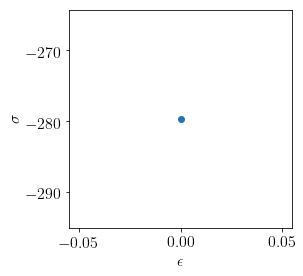

In [196]:
fig = plt.figure( figsize = (4,4))
ax = fig.add_subplot(111)
#ax2 = ax.twinx()
ax.set_xlabel(r'$\epsilon$',fontsize=16)
ax.set_ylabel(r'$\sigma$',fontsize=16)
ax.tick_params(labelsize=16)
#ax.set_yscale('log')
#ax.set_ylim(1e6,1e8)
#ax2.tick_params(labelsize=16)
#ax.set_title(fileNamee[:-4])
#
#ax.plot(stress[:,0],stress[:,1],'-')

#--- point corresponding to strain maps
virial = []
mu = []
strain = []
times = coord_atoms_broken.keys()
times.sort()
for itime in times:
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] )
    volume = np.linalg.det( CellVectorOrtho )
    virial += [np.c_[coord_atoms_broken[itime]['c_1[4]']].astype(float).sum() / volume]
    mu += [np.c_[coord_atoms_broken[itime]['c_1[22]']].astype(float).sum() / volume]
    #--- strain
    dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
    l1=CellVector[ itime ][1,1]
    strain += [0.5*dx/l1]

#--- plot stress
ax.plot(2*np.array(strain),np.array(virial),'-o')

#--- fit
coeffs = np.polyfit(2*np.array(strain)[1:],np.array(virial)[1:], 1)
def func(x, m, b):
    return m*x+b


#--- print fit
ax.plot(2*np.array(strain),func(2*np.array(strain), *coeffs),'-.r')

#
plt.savefig('stressStrain.png',dpi=75,bbox_inches='tight')
plt.show()

# Born Modulus

## Bulk value

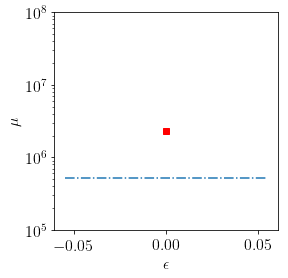

In [197]:
fig = plt.figure( figsize = (4,4))
ax = fig.add_subplot(111)
#ax2 = ax.twinx()
ax.set_xlabel(r'$\epsilon$',fontsize=16)
ax.set_ylabel(r'$\mu$',fontsize=16)
ax.tick_params(labelsize=16)
ax.set_yscale('log')
ax.set_ylim(1e5,1e8)
#ax2.tick_params(labelsize=16)
#ax.set_title(fileNamee[:-4])
#
#ax.plot(stress[:,0],stress[:,1],'-')

#--- plot mu
ax.plot(2*np.array(strain),np.array(mu),'-rs', label='Born')

#--- plot stress
#ax.plot(2*np.array(strain),np.array(virial),'-o')
#ax.plot(2*np.array(strain),np.gradient(virial,2*np.array(strain)),'-o')
ax.plot(ax.axis()[:2],[ coeffs[0], coeffs[0] ],'-.', label='estimate')

#
plt.savefig('bornModulus.png',dpi=75,bbox_inches='tight')
plt.show()

## PDF

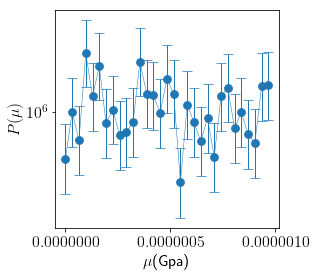

In [234]:
def GetPDF(slist, n_per_decade=4, ACCUM = None, linscale = None):
    if not linscale:
        xlo = np.floor(np.log10(np.min(slist)))
        xhi = np.ceil(np.log10(np.max(slist)))
        bins = np.logspace(xlo,xhi,int(xhi-xlo)*n_per_decade)    
    else:
        xlo = np.min(slist)
        xhi = np.max(slist)
        bins = np.linspace(xlo,xhi,n_per_decade)
        
    hist, edges = np.histogram(slist,bins=bins,density=True)
    count, edges = np.histogram(slist,bins=bins)
    
    
    if ACCUM:
        return np.cumsum((edges[1:]-edges[:-1])*hist), edges
    
    
    hist = hist[count>0]
    edges = edges[:-1][count>0]
    count = count[count>0]
    
    return  hist, edges, hist / count**0.5



#--- size distribution
itime = 0
value = np.c_[coord_atoms_broken[itime]['c_1[22]']].astype(float)*1e-6
hist, edges2, error = GetPDF( value, linscale = True, n_per_decade=32)

#--- plot
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_ylim(1e-10,1e-4)
ax.set_xlabel(r'$\mu$(Gpa)',fontsize=16)
ax.set_ylabel(r'$P(\mu)$',fontsize=16)
ax.tick_params(labelsize=16)
#ax.set_title(r'$\tau=%2.1f$'%tau)
#
ax.errorbar(edges2,hist,error,fmt='-o',
            markersize=8,markeredgewidth=0.7,
                linewidth=.5,
                 barsabove=None,capsize=5,capthick=1,elinewidth=1)
#
plt.savefig('muPDF.png',dpi=75,bbox_inches='tight')
plt.show()

## Interpolation


### mapping & add copies

In [8]:
def ChangeBasis( coord_atoms_broken, CellVector, CellOrigin, **kwargs ):
############################################################
####### map atoms within a tilted box to an orthogonal one
############################################################

    DimensionlessCords = GetDimensionlessCords( CellVector, coord_atoms_broken, CellOrigin  ) #--- beta0, beta1, beta2

    #--- shift (beta0 + beta1 * dx / |b0| > 1) by - b0
    #--- [b0,b1]^{-1}*(x=|b0|,y)
    
    b2 = CellVector[:,2]
    b1 = CellVector[:,1]
    b0 = CellVector[:,0]
    norm_b0 = np.dot(b0,b0)**0.5
    shift0 = np.dot(b1, b0 / norm_b0 )
    #
    indices_shiftTrue = (DimensionlessCords['beta0']) + (DimensionlessCords['beta1'])*shift0/norm_b0 >= 1.0
    n = len( indices_shiftTrue )
    shift_matrix =  np.array(indices_shiftTrue).reshape((n,1)) * b0
    #
    xyz = coord_atoms_broken - shift_matrix
    #
    attr_list = ['x','y','z']
    values = xyz
    for keys in kwargs:
        attr_list += [ keys ]
        values = np.c_[values,kwargs[keys]]
                
    return pd.DataFrame( values, columns = attr_list )

def AddCopies( coord_atoms_broken, CellVector, **kwargs ):    
    #--- orignial cell
    XYZ_shifted = coord_atoms_broken
    xyz_original = XYZ_shifted.copy()
    #---
    attr_list = ['x','y','z']
    values = XYZ_shifted
    for keys in kwargs:
        attr_list += [ keys ]
        values = np.c_[values,kwargs[keys]]

    ID_TYPE_shifted = values[:,3:]
    id_type_original = ID_TYPE_shifted.copy()
    
    #--- cell copies
    for i in [-1,0,1]:
        for j in [-1,0,1]:
            for k in [-1,0,1]:
    #            print i,j,k
                if i == j == k == 0:
                    continue
                total_shift = np.matmul( CellVector, np.array([i,j,k]) )
                #--- add shift
                xyz_shifted = xyz_original + total_shift
                #--- append
                XYZ_shifted = np.concatenate( ( XYZ_shifted, xyz_shifted ), axis = 0 )
                ID_TYPE_shifted = np.concatenate( ( ID_TYPE_shifted, id_type_original ), axis = 0 )
                                
    return pd.DataFrame(np.c_[XYZ_shifted,ID_TYPE_shifted],columns=attr_list)

def GetDimensionlessCords( CellVector, coord_atoms_broken, CellOrigin, **kwargs  ):
    xyz_centered = coord_atoms_broken - CellOrigin
    beta = np.matmul( np.linalg.inv(CellVector), xyz_centered.T).T
    
    attr_list = ['beta0', 'beta1', 'beta2']
    values = beta
    for keys in kwargs:
        attr_list += [ keys ]
        values = np.c_[values,kwargs[keys]]
        
    return pd.DataFrame( values, columns = attr_list  )

def shiftBeta( xyzDimensionless_j, diff, key = 'beta0' ):
    indices = diff[key] > 0.5
    beta0_j = xyzDimensionless_j[key] - 1.0 * indices

    indices = diff[key] < -0.5
    beta0_j += 1.0 * indices
    
    return beta0_j

def GetXYZ( CellVector, CellOrigin, DimensionlessCords, attr_list = ['x','y','z'], **kwargs ):
    XYZ_centered = np.matmul( CellVector, DimensionlessCords.T ).T #--- xyz in reference state
    XYZ = XYZ_centered + CellOrigin
    
    
    values = XYZ
    for keys in kwargs:
        attr_list += [ keys ]
        values = np.c_[values,kwargs[keys]]
        
    return pd.DataFrame( values, columns = attr_list)

def EstimateUnwrappedCord( coord_atoms_broken_i, coord_atoms_broken_j,
                           CellVector_i, CellVector_j,
                           CellOrigin_i, CellOrigin_j):
#--- dimensionless cords
    xyzDimensionless_i = GetDimensionlessCords( CellVector_i, coord_atoms_broken_i, CellOrigin_i )
    xyzDimensionless_j = GetDimensionlessCords( CellVector_j, coord_atoms_broken_j, CellOrigin_j )

    #--- shift to get unwrapped cords
    diff = xyzDimensionless_j[['beta0','beta1','beta2']] - xyzDimensionless_i[['beta0','beta1','beta2']]

    #--- new dimensionless cords
    beta0_j = shiftBeta( xyzDimensionless_j, diff, key = 'beta0' )
    beta1_j = shiftBeta( xyzDimensionless_j, diff, key = 'beta1' )
    beta2_j = shiftBeta( xyzDimensionless_j, diff, key = 'beta2' )

    #--- unwrapped cords at deformed state
    rj_unwrpd = GetXYZ( CellVector_j, CellOrigin_j, np.c_[beta0_j,beta1_j,beta2_j] )

    return rj_unwrpd

def GetPoints( CellOrigin, CellVector, xyz, ev = 0.2, output_attr = ['x','y','z'],**kwargs ):
    
    #--- tensor associated with dilation
    strainTensor = np.array([[ev/3.0,0,0],
                            [0,ev/3.0,0],
                            [0,0,ev/3.0]])
    #
    identityMat = np.array([[1,0,0],[0,1,0],[0,0,1]])
    #
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector )

    #--- extend diagonal
    rvect = -np.matmul( CellVectorOrtho, np.array([0.5,0.5,0.5]))
    CellOrigin_expanded = CellOrigin + np.matmul(strainTensor,rvect)

    #--- extend basis vectors
    CellVector_expanded = np.matmul( identityMat + strainTensor, CellVectorOrtho )

    #--- (beta0,beta1,beta2) associated with original atoms and their images 
    #--- with reference to the expanded box 
    DimensionlessCords = GetDimensionlessCords( CellVector_expanded, 
                                                xyz,
                                                CellOrigin_expanded,
                                                **kwargs )
    #--- filter: only inside the expanded box 
    index0 = np.all([DimensionlessCords['beta0'] >= 0.0, DimensionlessCords['beta0'] < 1.0], axis=0 )
    index1 = np.all([DimensionlessCords['beta1'] >= 0.0, DimensionlessCords['beta1'] < 1.0], axis=0 )
    index2 = np.all([DimensionlessCords['beta2'] >= 0.0, DimensionlessCords['beta2'] < 1.0], axis=0 )
    bete_inside = DimensionlessCords[np.all([index0,index1,index2],axis=0)]

    #--- xyz coordinates
    kwargss = {}
    for keys in kwargs:
        kwargss[ keys ] = bete_inside[ keys ]        
    xyz_inside = GetXYZ( CellVector_expanded, CellOrigin_expanded, 
                         np.c_[bete_inside[['beta0','beta1','beta2']]],
                         output_attr,
                         **kwargss )
    
    return xyz_inside




#------------------------------------------------------------------
#--- map coords and add images of atoms and relevant attributes
#------------------------------------------------------------------
coord = {}
for itime in coord_atoms_broken:
    #--- map atoms in the ref. state to an undeformed box
    df = coord_atoms_broken[ itime ][['id','type','x','y','z','c_1[22]']]
    xyz = np.c_[df[['x','y','z']].astype('float')]
    xyz_mapped = ChangeBasis( xyz, CellVector[ itime ], CellOrigin[ itime ] )

    #--- append ['xm','ym','zm']
    tmp = pd.DataFrame(np.c_[df, xyz_mapped],columns=['id','type','x','y','z','c_1[22]','xm','ym','zm'])
        
    #--- add copies ['x','y','z']
    df = tmp
    xyz = np.c_[df[['x','y','z']].astype('float')]
    xyz_copy = AddCopies( xyz, CellVector[ itime ],
                          id=df['id'],
                          type = df['type'],
                          mu = df['c_1[22]']
                        )
    #--- add copies ['xm','ym','zm']
    xyz_m = np.c_[df[['xm','ym','zm']].astype('float')]
    xyz_m_copy = AddCopies( xyz_m, CellVector[ itime ],
                          id=df['id'],
                          type = df['type'],
                           mu = df['c_1[22]']
                       )
    coord[itime] = pd.DataFrame(np.c_[xyz_copy[['id','type','x','y','z','mu']],xyz_m_copy[['x','y','z']]],columns=['id','type','x','y','z','mu','xm','ym','zm'])


### cubic grid

In [9]:
def GetCubicGrid( CellOrigin, CellVector, dmean, margin  ):

    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector )
    
    volume = np.linalg.det( CellVectorOrtho )


    [nx, ny, nz] = map( int, (np.array(VectorNorm)+2*margin) / dmean )
    if nx%2 == 0:
        nx += 1
    if ny%2 == 0:
        ny += 1
    if nz%2 == 0:
        nz += 1
    
    x = np.linspace( CellOrigin[0] - margin, CellOrigin[0] + VectorNorm[ 0 ] + margin, nx,endpoint=False)
    y = np.linspace( CellOrigin[1] - margin, CellOrigin[1] + VectorNorm[ 1 ] + margin, ny,endpoint=False)
    z = np.linspace( CellOrigin[2] - margin, CellOrigin[2] + VectorNorm[ 2 ] + margin, nz,endpoint=False)

    return (x, y, z), np.meshgrid(x, y,z)



#--- mean dist between atoms 
natoms = len( coord_atoms_broken[ 0 ] ) 
CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ 0 ] )
volume = np.linalg.det( CellVectorOrtho )
dmean = 0.5 * ( volume / natoms ) ** (1.0/3.0) 

#--- grid tiling mapped box with original size
#--- values are interpolated onto this grid
(xlin, ylin, zlin), (xv, yv, zv) = GetCubicGrid( CellOrigin[ 0 ], 
                                                 CellVector[ 0 ], 
                                                 dmean,
                                                 margin = 0.0 * dmean )
xi = np.array(zip(xv.flatten(), yv.flatten(), zv.flatten()))


### center box + margin

In [15]:
df_intrp = {}
for time_i in coord.keys():
#     if time_i > 0: #???????????
#         continue
    print time_i
    #--- get a chunck of full copies
    df_i = coord[ time_i ]
    
     #--- get points from which values are interpolated
    pointsValues =  GetPoints( CellOrigin[ time_i ], 
                               CellVector[ time_i ],
                               np.c_[df_i[['xm','ym','zm']]].astype('float'), #--- give mapped coordinates
                               ev = 0.1,
                               output_attr = ['xm','ym','zm'],
                               id = df_i['id'],
                               type = df_i['type'],
                               x = df_i['x'],
                               y = df_i['y'],
                               z = df_i['z'],
                               mu = df_i['mu'],
                             )
        
    #--- interpolate
#     points = pointsValues[['xm','ym','zm']]
#     values = pointsValues[['mu']]
#     grid_z = scp_int.griddata(points, values, xi, method='linear')
#     assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'
    

    x, y, z, d = np.c_[pointsValues[['xm','ym','zm','mu']]].T
    rbfi = Rbf(x, y, z, d, function = 'gaussian', epsilon = dmean)  # radial basis function interpolator instance
    grid_z = rbfi(xlin, ylin, zlin)   # interpolated values
    
    #--- store in dataframe
    df_intrp[ time_i ] = pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z','mu'])


0


In [279]:
#df_intrp[0]['mu'] = np.random.random(size=len(df_intrp[0]))

In [285]:
mu_born = {}
for itime in df_intrp:
    mu_born[itime] = df_intrp[ itime ]


### imshow

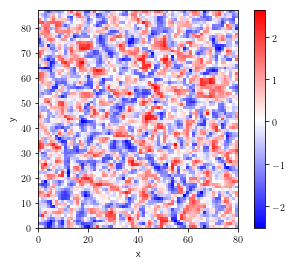

In [286]:
def FilterMatrix( CellVector, CellOrigin,
                  (xlin, ylin, zlin),
                  (xv, yv, zv ),
                   value
                ):
    #--- xlims of the original box
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector )
    margin = 0.0    
    (xlo,xhi)=( CellOrigin[0] - margin, CellOrigin[0] + VectorNorm[ 0 ] + margin)
    (ylo,yhi)=( CellOrigin[1] - margin, CellOrigin[1] + VectorNorm[ 1 ] + margin)
    (zlo,zhi)=(CellOrigin[2] - margin, CellOrigin[2] + VectorNorm[ 2 ] + margin )

    #--- grid dimension tiling the original box
    indices = np.all([xlin>=xlo, xlin<xhi],axis=0)
    nx = xlin[indices].shape[0]
    indices = np.all([ylin>=ylo, ylin<yhi],axis=0)
    ny = ylin[indices].shape[0]
    indices = np.all([zlin>=zlo, zlin<zhi],axis=0)
    nz = zlin[indices].shape[0]

    #--- filter matrices
    indices = np.all([xv>=xlo,xv<xhi, yv>=ylo,yv<yhi, zv>=zlo,zv<zhi ],axis=0)
    vf_flatten = value[indices] #--- filter extended grid
    assert vf_flatten.shape[0] == nx*ny*nz, '%s != %s'%(vf_flatten.shape[0], nx*ny*nz)
    vf = vf_flatten.reshape((ny,nx,nz))
    return vf

def CenterMatrix(a):
    ( mgrid, ngrid ) = a.shape
    return np.array([[ a[i,j] for j in xrange(-(ngrid/2),ngrid/2+ngrid%2)] 
                              for i in xrange(-(mgrid/2),mgrid/2+mgrid%2)])

def PltBitmap( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
             ):
        
    val = value.copy()
    #--- z-score
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
#         val[val>2.0]=1.0
#         val[val<-2.0]=-1.0
    #--- plot
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    pos = plt.imshow(val.real,cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]),origin='lower')# ,vmin=-.6, vmax=.6)
#    plt.xlim(center[0]-(ngrid/2)*frac,center[0]+(ngrid/2)*frac)
#    plt.ylim(center[1]-(mgrid/2)*frac,center[1]+(mgrid/2)*frac)
#    plt.xlim(xlim[0]*frac,xlim[1]*frac)
#    plt.ylim(ylim[0]*frac,ylim[1]*frac)
    plt.colorbar( pos, fraction = 0.04)
    plt.savefig('cxy.png',dpi=75,bbox_inches='tight')
    plt.show()


    

itime = 0
#--- reshape value
nx,ny,nz = len(xlin), len(ylin),len(zlin) 
value = np.c_[mu_born[itime]['mu']].reshape(((ny,nx,nz)))
#--- filter value
# value = FilterMatrix( CellVector[0], CellOrigin[0],
#                   (xlin, ylin, zlin),
#                   (xv, yv, zv ),
#                    value )
#print value.shape
#print vf.shape

CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] ) #--- box length
#--- xy plane
val = value[:,:,-1].copy()
#print val.shape

PltBitmap(val, 
          xlabel = 'x', ylabel = 'y',
          xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
          zscore = True,
          frac = 1.0, #--- plot a patch
        )

In [242]:
mu_born[itime].head()

,x,y,z,mu
0,-39.973239,-43.551705,-43.591808,0.230254
1,-39.973239,-43.551705,-42.459553,0.386032
2,-39.973239,-43.551705,-41.327299,0.412369
3,-39.973239,-43.551705,-40.195044,0.597766
4,-39.973239,-43.551705,-39.062789,0.664338


### Auto-Correlations

In [243]:
def GetAutoCorrelation( val ):
    value  = val.copy()
    value -= np.mean( value )
    value /= np.std( value )

    ( nx, ny, nz ) =  value.shape
    n = nx * ny * nz
    vq = np.fft.fftn(value) #, axes=(0,1,2))
    vq_sq = np.abs(vq)**2

    v_real = np.fft.ifftn( vq_sq) / n #,  axes=(0,1,2) )
    return v_real


Crltn = {}
for itime in mu_born:
    #
    (nx,ny,nz) = len(xlin), len(ylin),len(zlin) 
    #
    value = np.c_[mu_born[itime]['mu']].reshape(((ny,nx,nz)))
    #
    #--- filter value
#     value = FilterMatrix( CellVector[0], CellOrigin[0],
#                   (xlin, ylin, zlin),
#                   (xv, yv, zv ),
#                    value )

    Crltn[ itime ] = GetAutoCorrelation( value )


In [287]:
def GetAutoCorrelation2d( val ):
    value  = val.copy()
    value -= np.mean( value )
    value /= np.std( value )

    ( nx, ny ) =  value.shape
    n = nx * ny
    vq = np.fft.fft2(value) #, axes=(0,1,2))
    vq_sq = np.abs(vq)**2

    v_real = np.fft.ifft2( vq_sq) / n #,  axes=(0,1,2) )
    return v_real



val = value[:,:,-1].copy()
Crltn = GetAutoCorrelation2d( val )


#### Print

itime= 0


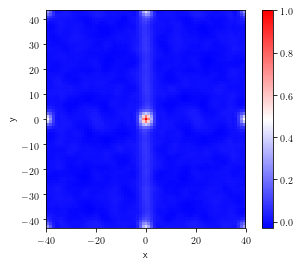

In [220]:

def PltCrltn( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              fileName = 'cxy.png',
              dpi=75,
            ):
        
    val = value.copy()
    #--- zscore
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
        val[val>2.0]=1.0
        val[val<-2.0]=-1.0
    #
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    pos = plt.imshow((CenterMatrix( val ).real),cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1])) #,vmin=-.01, vmax=.01)
    plt.xlim(xlim[0]*frac,xlim[1]*frac)
    plt.ylim(ylim[0]*frac,ylim[1]*frac)

    plt.colorbar( pos, fraction = 0.04)
    plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
    plt.show()


for itime in Crltn:
    print 'itime=',itime
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] ) #--- box length
    #    
    crltn = Crltn[ itime ]
    #--- xy plane
    val = crltn[:,:,0].copy()
    PltCrltn( val, 
              xlabel = 'x', ylabel = 'y',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              frac = 1, #--- plot a patch
              zscore = False,
              fileName = 'cxy.%s.png'%itime,
              dpi = 60
            )
    # #--- zx plane
    # val = crltn[0,:,:].copy()
    # PltCrltn( val, 
    #           xlabel = 'z', ylabel = 'x',
    #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[0]*np.array([-0.5,0.5]),
    #           frac = 1.0, #--- plot a patch
    #           zscore = False,
    #         )
    # #--- zy plane
    # val = crltn[:,0,:].copy()
    # PltCrltn( val, 
    #           xlabel = 'z', ylabel = 'y',
    #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
    #           frac = 1.0, #--- plot a patch
    #           zscore = False,
    #         )



itime= 0


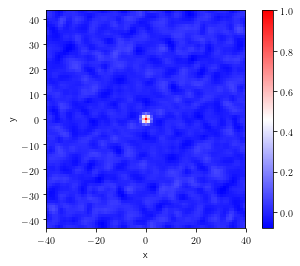

In [288]:

def PltCrltn( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              fileName = 'cxy.png',
              dpi=75,
            ):
        
    val = value.copy()
    #--- zscore
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
        val[val>2.0]=1.0
        val[val<-2.0]=-1.0
    #
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    pos = plt.imshow((CenterMatrix( val ).real),cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1])) #,vmin=-.01, vmax=.01)
    plt.xlim(xlim[0]*frac,xlim[1]*frac)
    plt.ylim(ylim[0]*frac,ylim[1]*frac)

    plt.colorbar( pos, fraction = 0.04)
    plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
    plt.show()


    
for itime in [0]:
    print 'itime=',itime
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] ) #--- box length
    #    
    crltn = Crltn
    #--- xy plane
    val = crltn
    PltCrltn( val, 
              xlabel = 'x', ylabel = 'y',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              frac = 1, #--- plot a patch
              zscore = False,
              fileName = 'cxy.%s.png'%itime,
              dpi = 60
            )
    # #--- zx plane
    # val = crltn[0,:,:].copy()
    # PltCrltn( val, 
    #           xlabel = 'z', ylabel = 'x',
    #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[0]*np.array([-0.5,0.5]),
    #           frac = 1.0, #--- plot a patch
    #           zscore = False,
    #         )
    # #--- zy plane
    # val = crltn[:,0,:].copy()
    # PltCrltn( val, 
    #           xlabel = 'z', ylabel = 'y',
    #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
    #           frac = 1.0, #--- plot a patch
    #           zscore = False,
    #         )



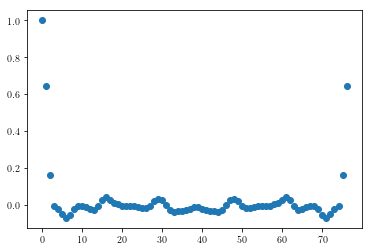

In [289]:
plt.plot(val[:,0],'o')
plt.show()

#### Crltn Length

itime= 0


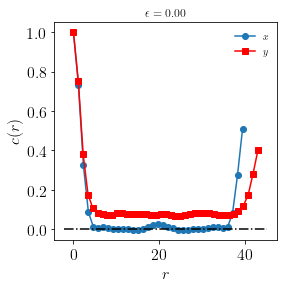

4.634578425113034 6.787278732233787


In [223]:
def Get_rc( xdata, ydata, cTOL ):
    try:
        xc1 = xdata[np.abs(ydata)<cTOL][0] 
    except:
        xc1 = np.nan
    try:    
        xc2 = xdata[ydata<0.0][0] #--- correlation length
    except:
        xc2 = np.nan
    try:
        xc = np.array([xc1,xc2])
        xc = xc[~np.isnan(xc)].min()
    except:
        xc = np.nan
    return xc

def PltCrltnFunc( crltn, 
                 (xv,yv),
                 cTOL = 1.0e-2,
                 PLOT = True,
                 fileName='cxy.png',
                 title = '',
                 dpi = 60,
                ):
    if PLOT:
        fig = plt.figure( figsize = (4,4))
        ax = fig.add_subplot(111)
        xstr = r'$r$'
        ystr = r'$c(r)$'
        ax.set_xlabel(xstr,fontsize=16)
        ax.set_ylabel(ystr,fontsize=16)
        ax.tick_params(labelsize=16)
    #
    val = crltn[:,:,0].copy() #--- only xy plane
    (m,n)=val.shape
    #--- along x 
    xv2 = xv[:,:,0].copy()
    dx = xv2[0,1] - xv2[0,0]
    #
    xdata = np.arange(0,(n/2+n%2)) * dx
    ydata = val[0,0:(n/2+n%2)]
    #
    xc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.plot( xdata, ydata,'-o',label=r'$x$')       
    #--- along y 
    yv2 = yv[:,:,0].copy()
    dy = yv2[1,0] - yv2[0,0]
    #
    xdata = np.arange(0,(m/2+m%2)) * dy
    ydata = val[0:(m/2+m%2),0]
    #
    yc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.plot( xdata, ydata,'-s', color = 'red',label=r'$y$')
    #--- plot
    if PLOT:
        ax.legend(frameon=False)
        ax.set_title( title )
        #ax.set_yscale('log')
        #
        ax.plot(ax.axis()[:2],[0.0,0.0],'-.',color='black')
#        ax.plot((rc,rc),ax.axis()[2:],'-.r')
        #
        #
        plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
        plt.show()
    #
    return (xc, yc)
    
    

for itime in Crltn:
    print 'itime=',itime
    #--- bulk strain
    dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
    l1=CellVector[ itime ][1,1]
    ebulk = 0.5*dx/l1
    #---
    xc, yc = PltCrltnFunc( Crltn[ itime ], 
                 (xv,yv),
                 fileName = 'cr.%s.png'%itime,
                 title = r'$\epsilon=%3.2f$'%(2*ebulk),
                 cTOL = 8.0e-2,
                 dpi = 60,
                )
    print xc, yc

In [72]:
mean = coord_atoms_broken[itime]['c_1[22]'].astype(float).mean()
std = coord_atoms_broken[itime]['c_1[22]'].astype(float).std()
'%e'%(mean-2*std)

'-5.744436e+09'